### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Load processed dataset

In [3]:
path = '../data/bank-additional-full-processed.csv'
df = pd.read_csv(path,delimiter=',')
df.head()

,age,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,0,1,0,1,0,0,1,0,1,0
1,57,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,0,1,0,1,0,0,1,0,1,0
2,37,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,0,0,1,1,0,0,1,0,1,0
3,40,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,0,1,0,1,0,0,1,0,1,0
4,56,5,1,1,1.1,93.994,-36.4,4.857,5191.0,-1,...,0,1,0,0,1,0,1,0,1,0


### Split data into train and test sets

In [4]:
# Predictors
x = df.drop(['y'], 1)

# Target values
y = df['y']

# Divide into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

In [11]:
x_train.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0.])

### Baseline algorithms

Let us run some baseline algorithms with default hyper-parameters on the training data to see how they perform. We will consider the following algorithms: **Logistic regression**, **Random forest**, **Support vector machine**, **k-Nearest neighbor** and **Decision tree**. For each algorithm, we will perform 10-fold cross-validation on the training set and store the mean classification accuracy and mean AUC-ROC (Area under ROC curve) along with the standard deviations.

In [4]:
# Make a list of algorithms to implement
models = []
models.append(('Logistic regression', LogisticRegression()))
models.append(('Random forest', RandomForestClassifier()))
models.append(('Support vector machine', SVC()))
models.append(('k-Nearest neighbor', KNeighborsClassifier()))
models.append(('Decision tree', DecisionTreeClassifier()))

In [6]:
# Make a dataframe to store classification metrics
col = ['Algorithm', 'Mean AUC-ROC', 'S.D. AUC-ROC', 'Mean Accuracy', 'S.D. Accuracy']
df_results = pd.DataFrame(columns=col)
i = 0

# Fit the models one by one
for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=10)  # 10-fold cross-validation
    cv_auc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')
    cv_acc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100),
                         round(cv_auc_results.std()*100),
                         round(cv_acc_results.mean()*100),
                         round(cv_acc_results.std()*100)
                         ]
    i += 1
df_results.sort_values(by=['Mean AUC-ROC'], ascending=False)

/Users/ahanagangopadhyay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/ahanagangopadhyay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

,Algorithm,Mean AUC-ROC,S.D. AUC-ROC,Mean Accuracy,S.D. Accuracy
1,Random forest,77.17,0.89,89.16,0.19
0,Logistic regression,76.26,0.63,89.44,0.29
3,k-Nearest neighbor,73.13,1.04,88.68,0.22
4,Decision tree,63.23,0.62,84.35,0.29
2,Support vector machine,26.81,2.94,88.76,0.24


ROC_AUC_SCORE is 0.5899745251566824
Classification Report:
             precision    recall  f1-score   support

         -1       0.91      0.98      0.94      7303
          1       0.60      0.20      0.30       935

avg / total       0.87      0.89      0.87      8238



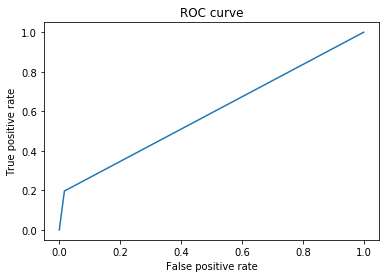

In [5]:
model = LogisticRegression()
model.fit(x_train, y_train)

# Predict on test set
y_scores = model.predict(x_test)

auc = roc_auc_score(y_test, y_scores)
print(f'ROC_AUC_SCORE is {auc}')
print('Classification Report:')
print(classification_report(y_test, y_scores))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()